# Bayesian computations with Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily compute the evidence and posterior of a neural network. The larger number of parameters means that we should be careful with how accurate we want this to be. With high precision, we'll need more likelihood evaluations.

## What we'll do in this notebook
1. Define a neural network model
2. Find its maximum likelihood parameters using Global Optimisation
3. Redefine it as a Bayesian neural network allowing biases to be sampled from a prior.
4. Compute the evidence and posterior of the parameters.


## Data

We'll use the N-bit majority problem as our data. This is a binary classification problem where the input is a sequence of bits and the output is 1 if the majority of the bits are 1, and 0 otherwise.

In [1]:
import os

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")
    raise

import jax
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
import numpy as np

np.random.seed(42)

tfpd = tfp.distributions


In [2]:
import itertools


# Generate data


def generate_parity_dataset(N):
    """
    Generates a dataset for the N-bit parity problem.

    Args:
        N (int): Number of bits in each sample.

    Returns:
        X (np.ndarray): Input features of shape (num_samples, N).
        y (np.ndarray): Labels of shape (num_samples,).
    """
    # Generate random binary inputs
    X = np.asarray(list(itertools.product([0, 1], repeat=N)))
    # Compute parity (even or odd number of ones)
    y = np.mod(np.sum(X, axis=1), 2)
    return X.astype(np.float32), y.astype(np.float32)


num_variables = 2
x, y = generate_parity_dataset(num_variables)
print("Data:")

for input, output in zip(x, y):
    print(f"{input} -> {output}")


Data:
[0. 0.] -> 0.0
[0. 1.] -> 1.0
[1. 0.] -> 1.0
[1. 1.] -> 0.0


In [3]:
from jaxns.internals.maps import pytree_unravel
from jaxns import Prior, Model
import jaxns.framework.context as ctx


def prior_model():
    def compute_logits(x):
        mlp = hk.Sequential([
            hk.Linear(5),
            jax.nn.sigmoid,
            hk.Linear(2),
            jax.nn.sigmoid,
            hk.Linear(1)])
        return mlp(x)

    init, apply = hk.transform(compute_logits)
    init_params = init(random.PRNGKey(0), x)
    # Convert haiku to jaxns params
    ctx_params = ctx.convert_external_params(init_params, prefix='haiku_model')
    # Flatten, model, then unflatten to use
    ravel_fn, unravel_fn = pytree_unravel(ctx_params)
    ndims = ravel_fn(init_params).size
    flat_params = yield Prior(tfpd.Uniform(-10. * jnp.ones(ndims), 10. * jnp.ones(ndims)), name='flat_params')
    params = unravel_fn(flat_params)
    logits = apply(params, jax.random.PRNGKey(0), x)
    return logits.astype(jnp.float32)


def log_likelihood(logits):
    # Classification probelm, so we use a Bernoulli likelihood
    return tfpd.Bernoulli(logits=logits).log_prob(y).mean()


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)




/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/internals/mixed_precision.py:14: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [4]:

model.sanity_check(random.PRNGKey(0), S=100)


INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


INFO:jaxns:Number of parallel Markov-chains set to: 1500


Running over 12 devices.
--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 5090124
samples: 13608
phantom samples: 0
likelihood evals / sample: 374.1
phantom fraction (%): 0.0%
--------
logZ=-2.045 +- 0.026
max(logL)=-0.693
H=-0.62
ESS=1857
--------
flat_params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
flat_params[0]: 0.1 +- 5.7 | -7.9 / 0.1 / 8.1 | -5.5 | -5.5
flat_params[1]: 0.4 +- 5.9 | -8.1 / 0.7 / 8.2 | -7.7 | -7.7
flat_params[2]: -0.1 +- 5.8 | -8.2 / -0.4 / 8.2 | -2.4 | -2.4
flat_params[3]: 0.1 +- 5.7 | -8.0 / 0.3 / 8.0 | 2.8 | 2.8
flat_params[4]: 0.3 +- 5.7 | -7.7 / 0.5 / 8.1 | -0.1 | -0.1
flat_params[5]: -0.1 +- 5.7 | -8.2 / -0.3 / 8.0 | 0.3 | 0.3
flat_params[6]: 0.1 +- 5.8 | -7.9 / 0.1 / 8.0 | 6.5 | 6.5
flat_params[7]: 0.3 +- 5.8 | -7.7 / 0.5 / 8.3 | -2.2 | -2.2
flat_params[8]: 0.3 +- 5.7 | -7.9 / 0.4 / 8.1 | 1.5 | 1.5
flat_params[9]: -0.1 +- 5.7 | -8.1 / -0.1 / 8.0 | -9.6 | -9.6
flat_params[10]: -0.1 +- 5.6 | -

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:49: RuntimeWarning: divide by zero encountered in divide
  1. / num_likelihood_evaluations_per_sample


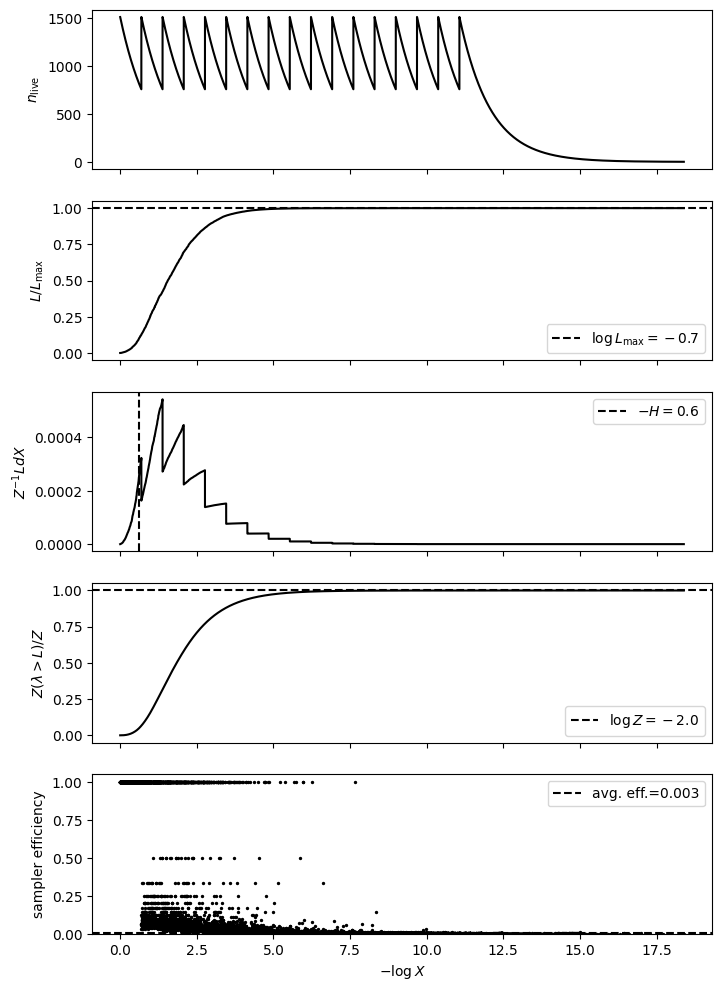

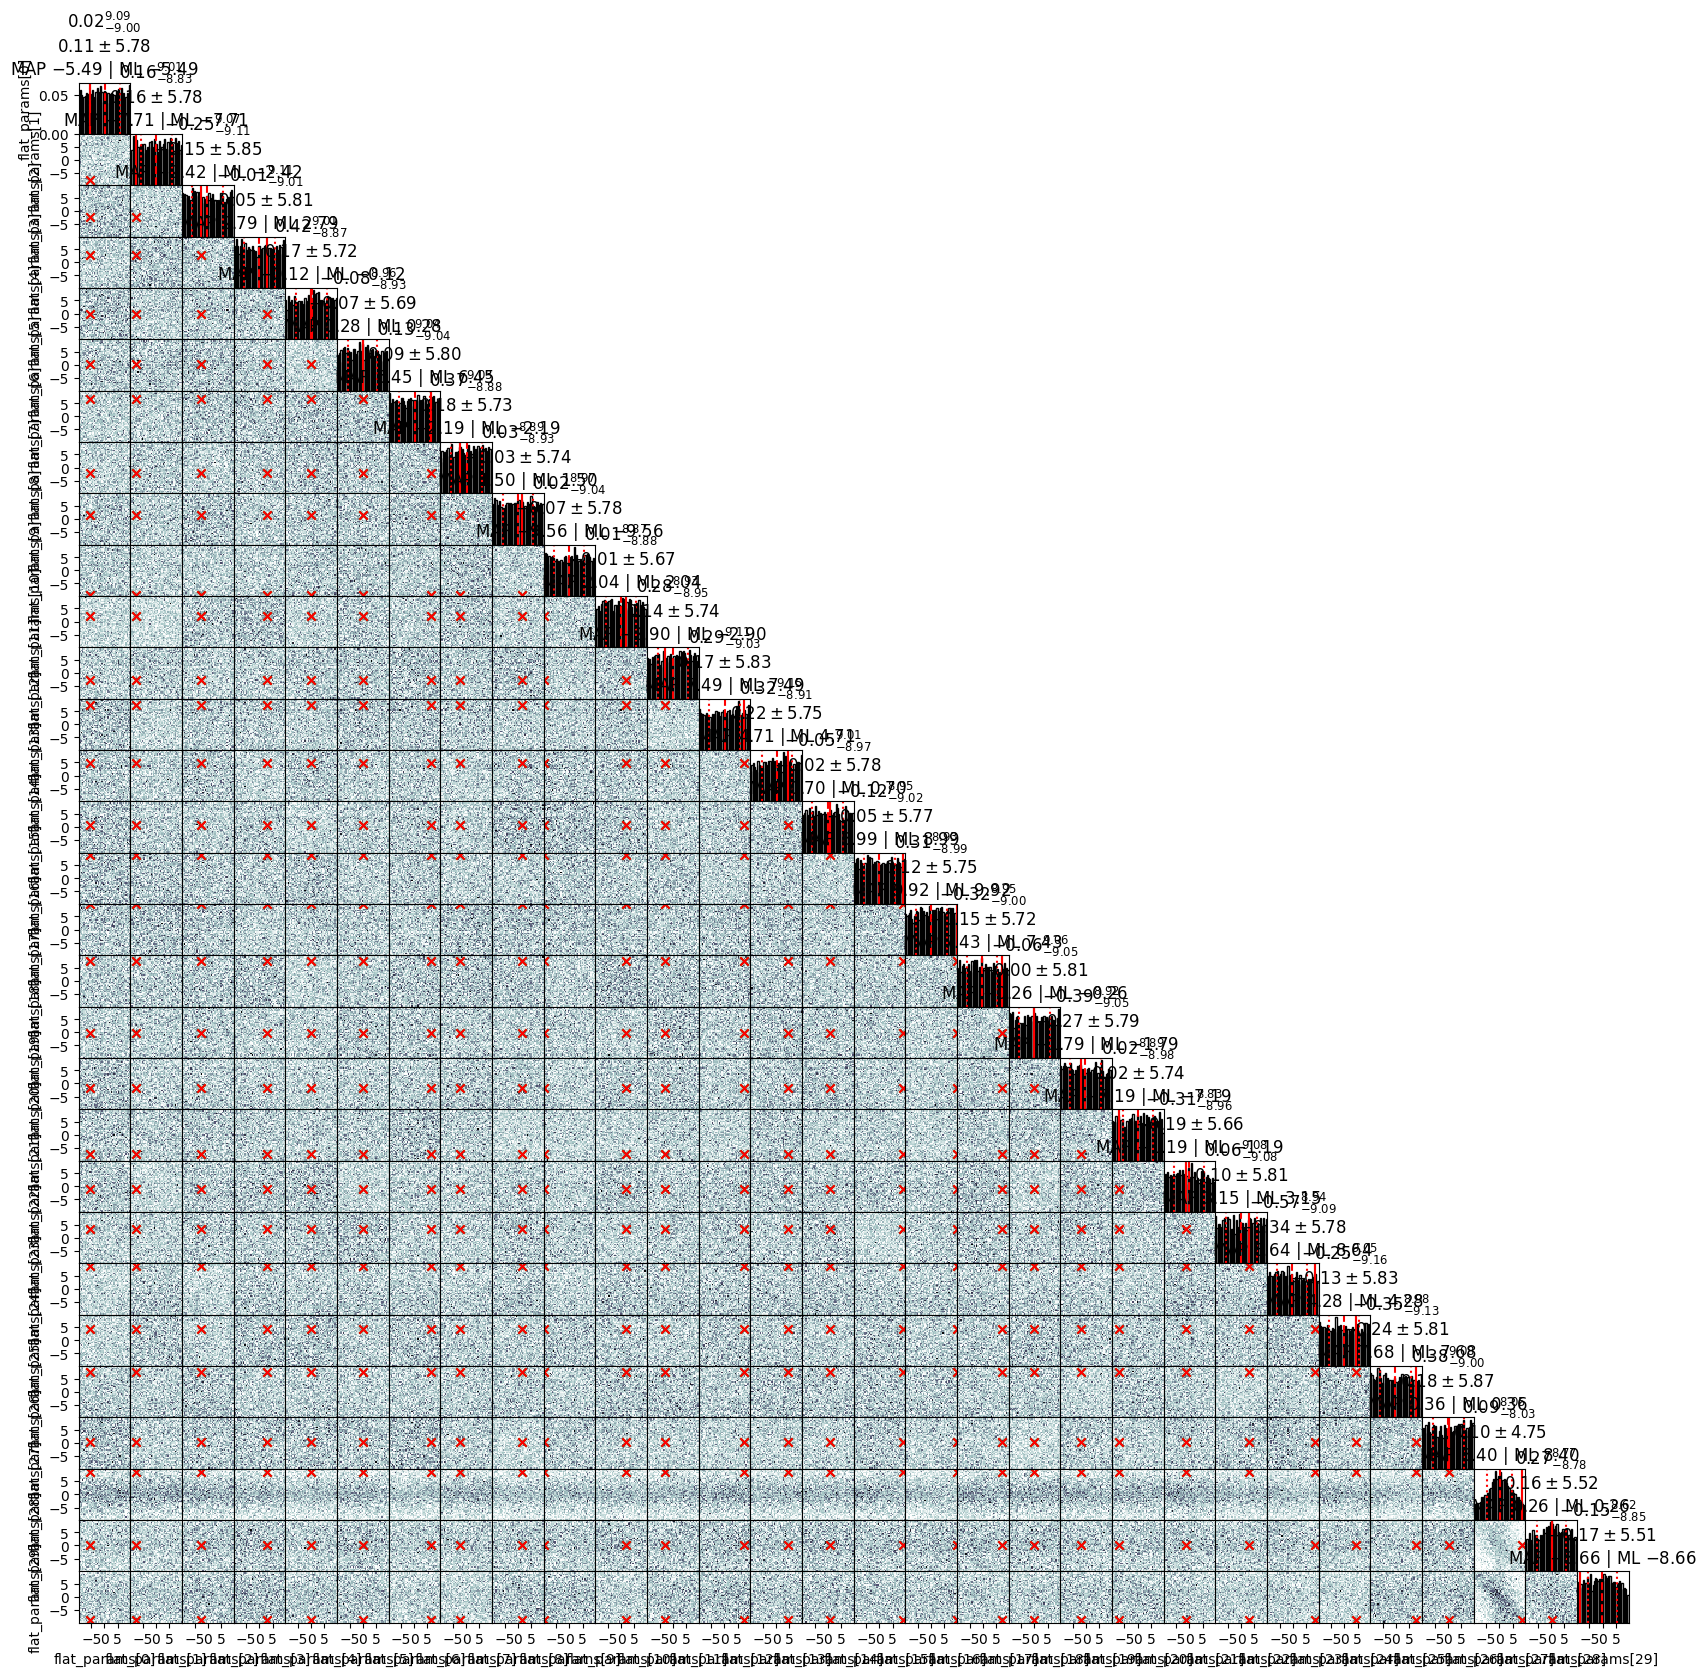

In [5]:
from jaxns import NestedSampler

ns = NestedSampler(model=model, num_live_points=model.U_ndims * 50)

term_reason, state = jax.jit(ns)(
    random.PRNGKey(42)
)
results = ns.to_results(term_reason, state)
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)

solution = results.U_samples[jnp.argmax(results.log_L_samples)]


In [6]:
logits = model.prepare_input(solution)[0]
predictions = jax.nn.sigmoid(logits)
for i in range(len(y)):
    pred = predictions[i]
    print(f"{i}: {x[i]} -> {y[i]} | pred: {pred} {'✓' if (pred > 0.5) == y[i] else '✗'}")

accuracy = jnp.mean((predictions > 0.5) == y)
print(f"Accuracy: {accuracy * 100:.1f}%")

0: [0. 0.] -> 0.0 | pred: [0.4998758] ✓
1: [0. 1.] -> 1.0 | pred: [0.49987462] ✗
2: [1. 0.] -> 1.0 | pred: [0.499882] ✗
3: [1. 1.] -> 0.0 | pred: [0.49987462] ✓
Accuracy: 50.0%
